# Text to image generation project Milestone 4

Ye Jin, Yu Leng, Yiheng Liu, 2023. April 24th. 

## Problem statement

In this project, we hope to design a Generative adversarial networks (GAN) model that could generate image based on text input. Specifically, we adopt the model architecture used in the recent research paper "Generative Adversarial Text to Image Synthesis" and train it on the Caltech-UCSD Birds-200-2011 Dataset (CUB). This dataset includes 11,788 images of 200 bird species, with each species varying in size (Wah et al. 2011). We selected this dataset because bird categorization has been a difficult task even for human due the subtle distinctions between each species. We believe that if our model can accurately identify these small differences and correctly match the images to the corresponding text, it would demonstrate strong generalizability and high performance.

In [6]:
# import necessary packages
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from PIL import Image
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Dropout, Concatenate, Conv2DTranspose, Conv2D, LeakyReLU, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
import pandas as pd


<h1 style="font-size: 24px;">Table of Contents</h1>

<ul style="font-size: 18px;">
  <li><a href="Exploratory Data Analysis">Exploratory Data Analysis</a></li>
    <ul>
      <li><a href="#subsection-a">Data Description</a></li>
      <li><a href="#subsection-b">Resize and Image processing </a></li>
    </ul>
  <li><a href="Baseline Model">Baseline Model</a>
  </li>
  <li><a href="GAN model">GAN model</a></li>
</ul>

## Exploratory Data Analysis

### Data Description ###

As described above, the CUB dataset consists a total 11788 images for 200 different bird species, with each species represented as around 60 images. At the same time, we also have 10 textual descriptions for each times that discribe what the bird look like. In this case, we will use both the text descriptions and images to train our model. In this section, we performed exploratory data analysis and resize our image to be the same size. We also test and prepare some data augmentation methods to increase the training size of the data later.


### Resize and Image processing

After performing exploratory data analysis, we discovered that the images in our dataset have varying shapes and sizes. With a large amount of image data (11788) and the large size of each image (around 300-500 width and height), it would be challenging to train a model using such voluminous data. As a solution, we decided to resize all images to the standard size of $64\times 64$, as outlined in the original paper (Reed et al. 2016). To achieve this, we had two options: either crop the image to a square format and then reduce the size, or use transparent padding to fill the image to a square format and then reduce the size to $64\times 64$. We tested both methods and save the processed images for future usage. Due to the long time for processing image, here we will only show the methods we used and perform the more EDA analysis on resized images only later.

#### Here's a histogram for our raw image sizes

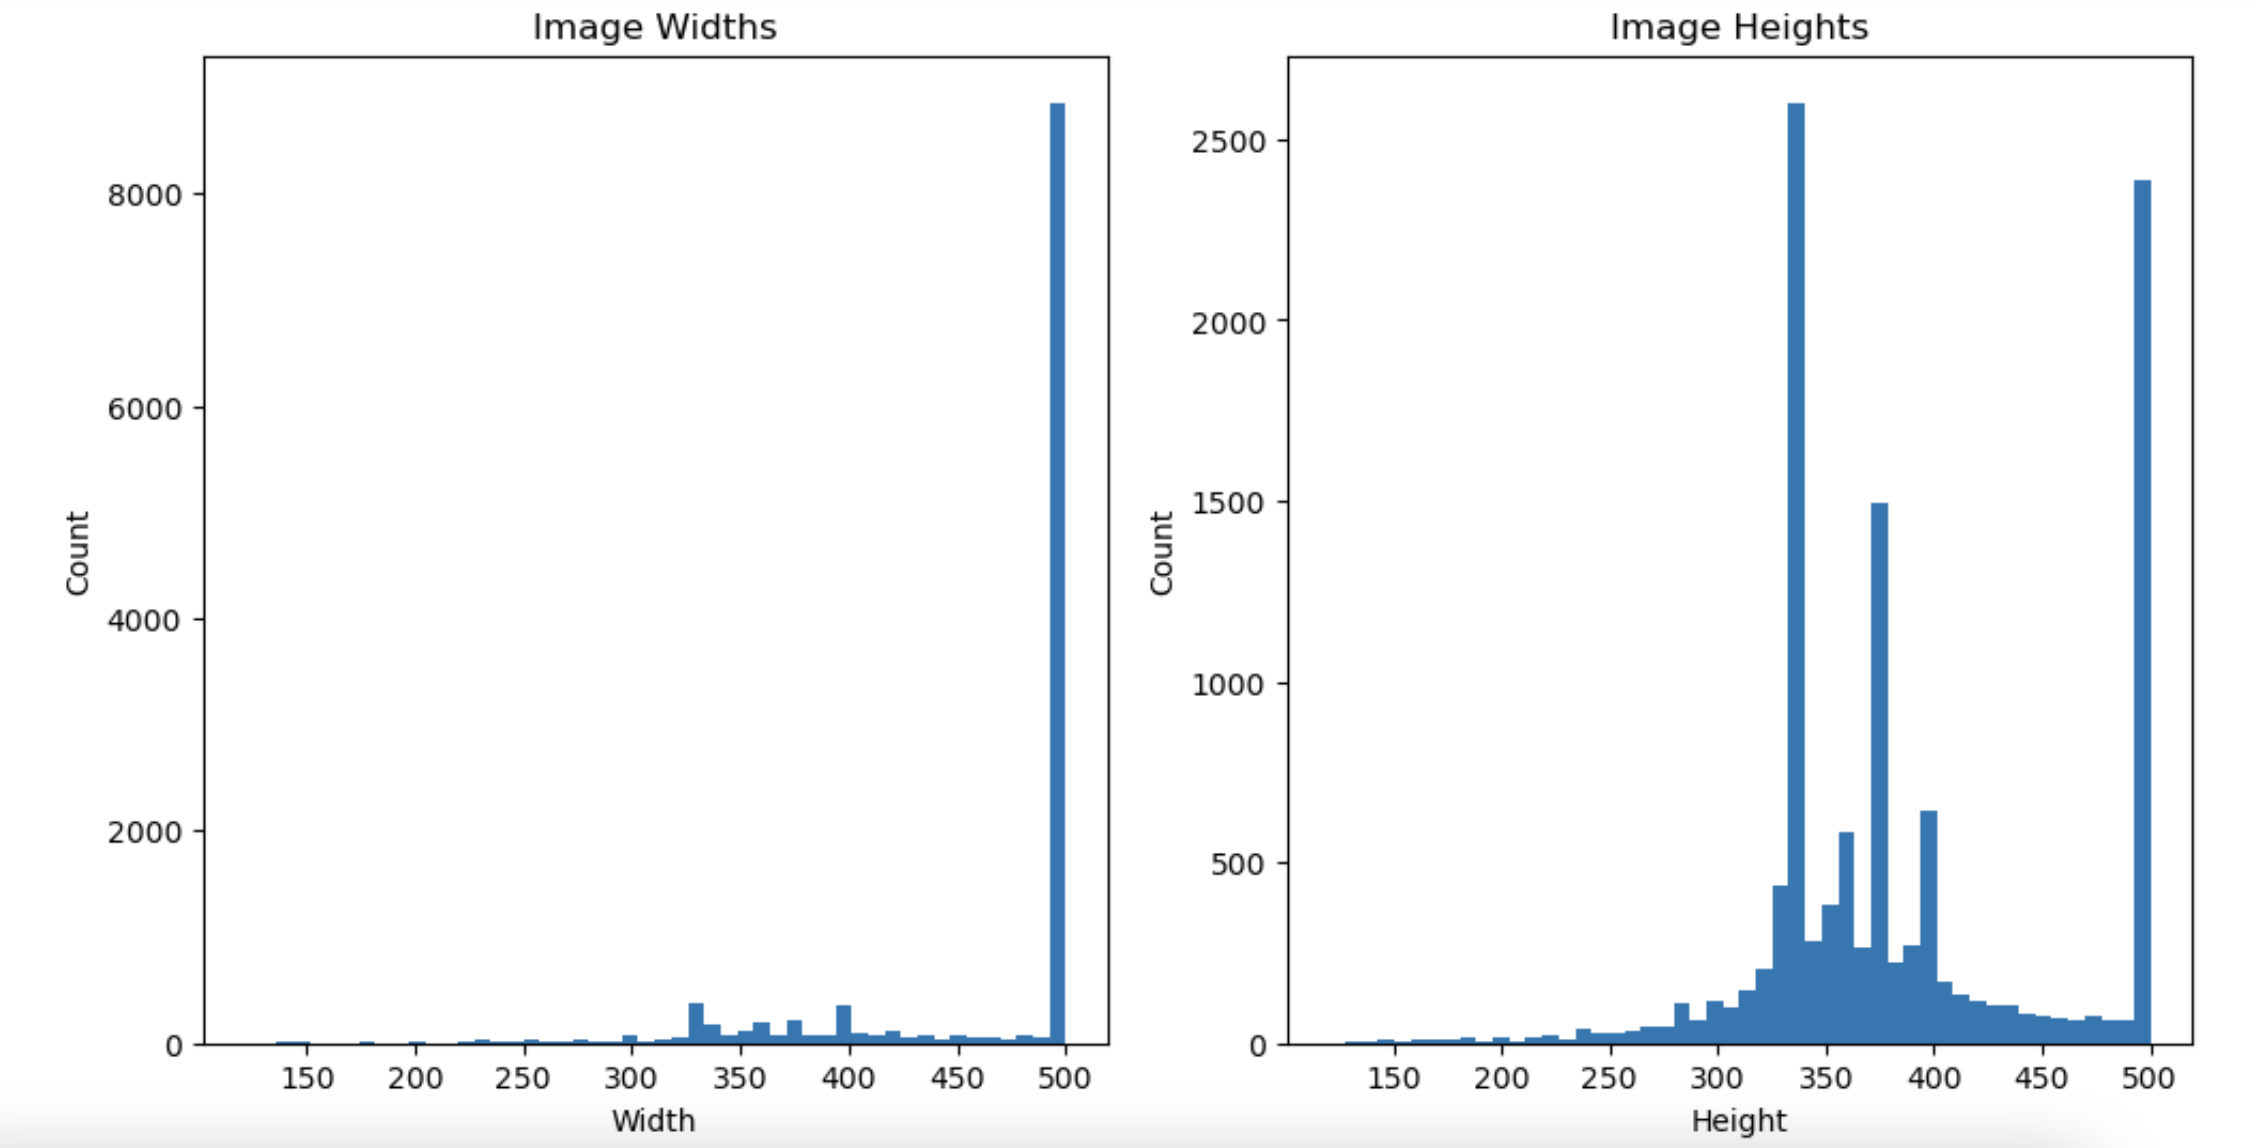

In [16]:
from IPython.display import Image
Image(filename='raw_image_shape.png')

### Here's an example image after central cropping and an example image after transparent padding

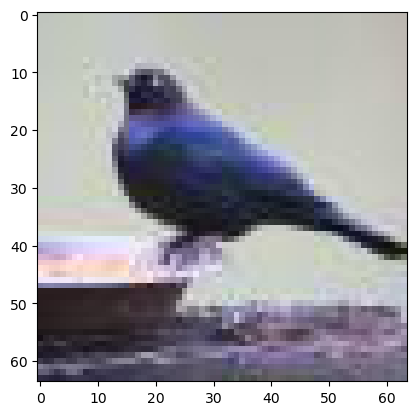

In [2]:
img = Image.open('resized_image/009.Brewer_Blackbird/Brewer_Blackbird_0080_2234.jpg')
plt.imshow(img)

In [3]:
def count_images(folder_path, image_ext='.jpg'):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    image_counts = {}
    
    for subfolder in subfolders:
        image_files = glob.glob(os.path.join(subfolder, f'*{image_ext}'))
        image_counts[os.path.basename(subfolder)] = len(image_files)
        subfolder_counts = count_images(subfolder, image_ext)
        for subfolder, count in subfolder_counts.items():
            image_counts[os.path.join(os.path.basename(subfolder), subfolder)] = count

    return image_counts

def compute_mean_image(folder_path, image_ext='.jpg'):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    image_sum = None
    num_images = 0

    for subfolder in subfolders:
        image_files = [f for f in os.listdir(subfolder) if f.endswith(image_ext)]
        for image_file in image_files:
            image_path = os.path.join(subfolder, image_file)
            image = Image.open(image_path)
            image_array = np.array(image)

            if image_sum is None:
                image_sum = image_array.astype(np.float64)
            else:
                image_sum += image_array.astype(np.float64)
            num_images += 1
    mean_image = (image_sum / num_images).astype(np.uint8)
    return Image.fromarray(mean_image)

def center_crop(img, new_width=None, new_height=None):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def resize_images(folder_path, output_folder_path, image_ext='.jpg', size=(64, 64)):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

    for subfolder in subfolders:
        output_subfolder = os.path.join(output_folder_path, os.path.relpath(subfolder, folder_path))
        os.makedirs(output_subfolder, exist_ok=True)

        image_files = [f for f in os.listdir(subfolder) if f.endswith(image_ext)]

        for image_file in image_files:
            image_path = os.path.join(subfolder, image_file)
            image = Image.open(image_path)
            
            tmp = cv2.resize(center_crop(asarray(image)), dsize = size,interpolation=cv2.INTER_AREA)
            resized_image = Image.fromarray(tmp)

            output_path = os.path.join(output_subfolder, image_file)
            resized_image.save(output_path)
            
def resize_images2(folder_path, output_folder_path, image_ext='.jpg', size=(64, 64)):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

    for subfolder in subfolders:
        output_subfolder = os.path.join(output_folder_path, os.path.relpath(subfolder, folder_path))
        os.makedirs(output_subfolder, exist_ok=True)

        image_files = [f for f in os.listdir(subfolder) if f.endswith(image_ext)]

        for image_file in image_files:
            image_path = os.path.join(subfolder, image_file)
            image = Image.open(image_path)
            
            max_size = max(image.size)
            new_image = Image.new('RGBA', (max_size, max_size), (0, 0, 0, 0))
            new_image.paste(image, (int((max_size-image.size[0])/2), int((max_size-image.size[1])/2)))
            resized_image = new_image.resize((64,64), Image.Resampling.LANCZOS)
            
            new_filename = image_file.replace('.jpg','.png')
            output_path = os.path.join(output_subfolder, new_filename)
            resized_image.save(output_path)

def get_histograms(folder):
    image_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg')):
                image_files.append(os.path.join(root, file))
    widths = []
    heights = []
    for file in image_files:
        with Image.open(file) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=50)
    plt.title('Image Widths')
    plt.xlabel('Width')
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=50)
    plt.title('Image Heights')
    plt.xlabel('Height')
    plt.ylabel('Count')
    
def color_analysis(folder_path):
    red_mean = []
    green_mean = []
    blue_mean = []
    red_std = []
    green_std = []
    blue_std = []

    for subfolder_name in os.listdir(folder_path):

        if not subfolder_name.startswith('.'):

            subfolder_path = os.path.join(folder_path, subfolder_name)

            for image_name in os.listdir(subfolder_path):

                if not image_name.startswith('.'):

                    image_path = os.path.join(subfolder_path, image_name)
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    color_mean = np.mean(image, axis=(0,1))
                    color_std = np.std(image, axis=(0,1))

                    red_mean.append(color_mean[0])
                    green_mean.append(color_mean[1])
                    blue_mean.append(color_mean[2])
                    red_std.append(color_std[0])
                    green_std.append(color_std[1])
                    blue_std.append(color_std[2])

    mean_values = [np.mean(red_mean), np.mean(green_mean), np.mean(blue_mean)]
    std_values = [np.mean(red_std), np.mean(green_std), np.mean(blue_std)]

    plt.figure(figsize=(8,5))
    plt.bar(['Red', 'Green', 'Blue'], mean_values, yerr=std_values, capsize=10)
    plt.title('Color Analysis')
    plt.xlabel('Channel')
    plt.ylabel('Mean Value')
    

def mean_image(folder_path):
    image_list = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    if img.mode == "RGB":
                        image_list.append(image_path)

    image_array = np.zeros((len(image_list), 64, 64, 3))
    for i, image_path in enumerate(image_list):
        image = Image.open(image_path)
        image_array[i, :, :, :] = np.array(image)

    mean_image = np.mean(image_array, axis=0)

    mean_image = np.uint8(mean_image)
    mean_image = Image.fromarray(mean_image)
    return mean_image

In [4]:
folder_path = 'resized_image'

#### Count the images number by bird type on the resized images

Text(0.5, 1.0, 'Image Counts by bird type')

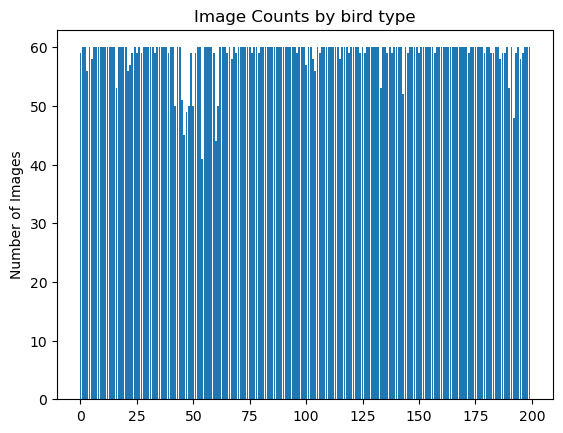

In [7]:
image_counts = count_images(folder_path)
plt.bar(range(len(image_counts)), list(image_counts.values()))
plt.ylabel('Number of Images')
plt.title('Image Counts by bird type')

Here we can see that almost all folders will have similar number of images for each bird category. Since we haven't perform data augmentation, we believe that the differences between each bird category will be further reduced after data augmentation.

#### Color Analysis for all raw images
We can see that the mean value and standard deviation for three channels in all bird images. In general, for the mean value, blue is a bit low while green and red are similar. For standard deviations, all three channels behave similar.

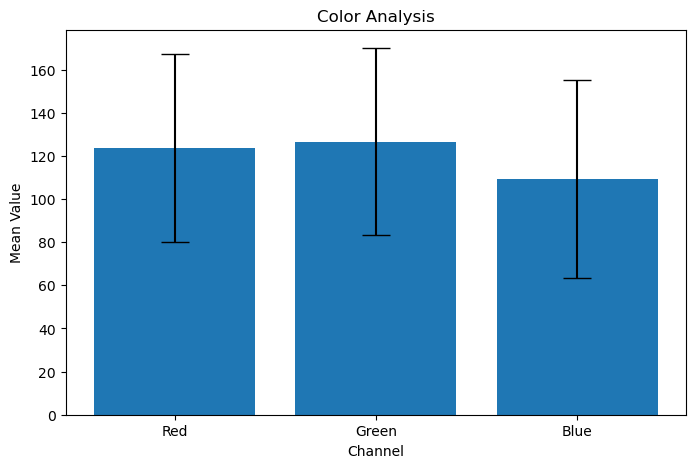

In [12]:
color_analysis(folder_path)

#### Mean Picture after resize ####

From the above analysis, it is reasonable to have the mean image to be almost grey, as shown below. The mean image is calculated through all cropped image after resizing to $64\times 64$.  

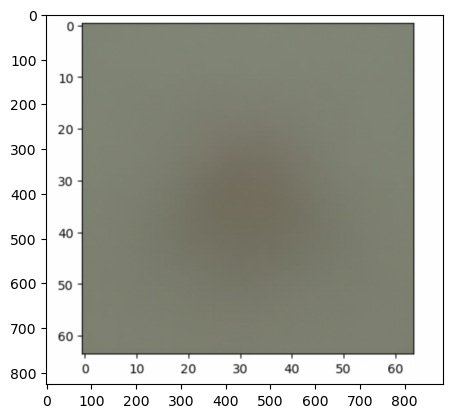

In [5]:
img = Image.open('mean_image_2.png')
plt.imshow(img)

#### PCA ####
Since there are too many images, we only conduct PCA for all images in the Black Footed Albatross category. We spread the three channels, and concatenate all images to conduct the PCA.  In analyzing the PCA plots, it is evident that after the image has undergone preprocessing, the first component consistently places the birds in the center of the image with lower pixel values. The second component indicates that the birds are frequently perched on some object. As a result, we can have a brief idea that the data preprocessing works well, and the image is ready for training. 

(64, 64)


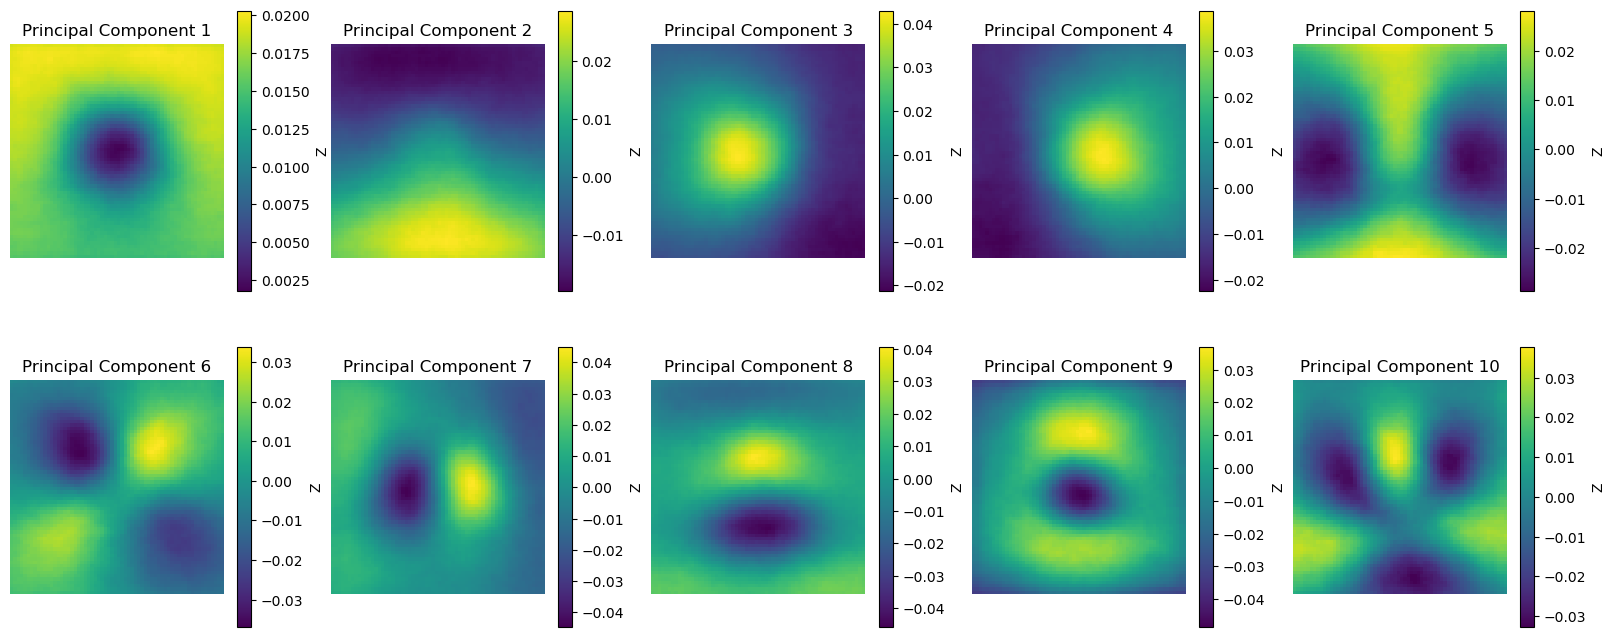

In [7]:
folder_path = "resized_image"

file_extensions = ["jpg", "jpeg", "png"]
file_list = []
for ext in file_extensions:
    file_list.extend(glob.glob(os.path.join(folder_path, "**/*." + ext), recursive=True))

image_vectors = []
for file_path in file_list:
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image_vector = image.flatten()
    image_vectors.append(image_vector)
image_vectors = np.array(image_vectors)

pca = PCA()
pca.fit(image_vectors)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
print(image.shape)
for i, ax in enumerate(axs.flat):
    result = ax.imshow(pca.components_[i].reshape(image.shape))
    ax.axis('off')
    ax.set_title("Principal Component {}".format(i+1))
    cbar = fig.colorbar(result)
    cbar.ax.set_ylabel('Z')
plt.show()

#### Data Augmentation
To introduce variations in bird pose and viewpoint, we can use the RandomRotation method to randomly rotate the image by a certain degree. The degree of rotation is crucial to balance the generation of variations and preservation of generalizability. We tested different degrees of rotation and concluded that a ±10° rotation is most suitable.
To simulate reflections of birds, we can use the RandomFlip method to flip the image horizontally or vertically. However, upside-down bird positions are unrealistic, so we randomly flip the image horizontally.
Adding Gaussian noise to an image using the RandomGaussianNoise method introduces random variations to the pixel values of our bird images.
However, since we hope to start training our gan with more flexibility, we won't perform data augmentation until we can the model and will do it as our need. Below in the model section we will discuss more about this.

## Baseline model

A traditional GAN is a common approach for image generation. It is composed of a generator and discriminator, and it takes in noise as input and generates fake images, and the discriminator takes in both fake and real images to conduct binary classification. Since we aim to build a model that could generate images given textual description, we adopted a conditional GAN as our baseline model, which has similar structure but takes additional information, in this case the textual information, in both generator and discriminator. 
For the textual information, we tried two different methods. The first is that we downloaded the pre-trained embeddings of textual description for XX’s research and directly passed them to the generator and discriminator. Another approach is that we used the BERT model to encode the textual descriptions of the images.
For the generator, we defined both noise and embeddings as inputs, and the generated image as output. The noise and embeddings are both 1D vectors, so we concatenated them and then passed them to convolutional layers and fully-connected layers. One thing to note is that since we want the discriminator to detect real and fake images, the generated images need to have the same shape as the real image, so the output image of the generator is also designed to be (64, 64, 3). 
For the discriminator, since we want it to learn both what real images look like and how the real images should associate with the real textual embeddings, we used three pairs of image and embedding as input, including the real image and real text embedding, fake image and real text embedding, as well as real image and fake text embedding. Only the first pair is labeled as real, the other two are both considered false. In the neural network, we first utilized convolutional layers to learn the features of the images, and then flattened the feature maps to 1D vector and concatenated it with the embeddings. Then, we passed them to fully-connected layers. The convolutional layers and dense layers all have ReLU as activation, only the final layer has sigmoid activation which is suitable for our task of binary classification.

### Load and Preprocess Data

In [4]:
# embeddings = pd.read_pickle("birds/train/char-CNN-RNN-embeddings.pickle")
# embeddings = np.array(embeddings)
# filenames = pd.read_pickle("birds/train/filenames.pickle")
# filenames = np.array(filenames)
embeddings = pd.read_pickle("embeddings_train.pickle")
embeddings = np.array(embeddings)
filenames = pd.read_pickle("filenames_train.pickle")
filenames = np.array(filenames)

In [5]:
Scarlet_Tanager = np.core.defchararray.find(filenames, 'Scarlet_Tanager')
Scarlet_Tanager = filenames[np.flatnonzero(np.core.defchararray.find(filenames, 'Scarlet_Tanager')!=-1)]
Scarlet_Tanager_embeddings = embeddings[np.flatnonzero(np.core.defchararray.find(filenames, 'Scarlet_Tanager')!=-1)]
Scarlet_Tanager_embeddings = Scarlet_Tanager_embeddings.reshape((-1, 1024))
print(Scarlet_Tanager_embeddings.shape)

(600, 1024)


In [6]:
from PIL import Image
import PIL
data_path = "./resized_image"

# load all images that are birds of type Scarlet Tanager
images = []
for name in Scarlet_Tanager:
    path = os.path.join(data_path, name+".jpg")
    with Image.open(path) as img:
        img = np.array(img)
        images.append(img)

# Convert the list of images to a NumPy array
images = np.array(images)

In [7]:
import random
# Define a function to apply random rotations to the image
def random_rotation(image, rotation_range):
    angle = random.uniform(-rotation_range, rotation_range)
    return image.rotate(angle)

# Define a function to apply random flips to the image
def random_flip(image):
    if random.random() > 0.5:
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    else:
        return image

# Define a function to apply random crops to the image
def random_crop(image, crop_size):
    width, height = image.size
    crop_height, crop_width = crop_size
    
    left = random.randint(0, width - crop_width)
    top = random.randint(0, height - crop_height)
    right = left + crop_width
    bottom = top + crop_height
    cropped_image = image.crop((left, top, right, bottom))
    pad_left = left
    pad_top = top
    pad_right = width - right
    pad_bottom = height - bottom
    padding = (pad_left, pad_top, pad_right, pad_bottom)
    padded_image = PIL.ImageOps.expand(cropped_image, padding, fill=0)
    return padded_image

In [8]:
from PIL import ImageOps
augmented_images = []
# perform data augmentation using the random functions
for image in images:
    image = Image.fromarray(image)
    for i in range(9):   # can modify    
        aug_image = random_rotation(image, 10)
        aug_image = random_flip(aug_image)
        aug_image = random_crop(aug_image, (60, 60))
        augmented_images.append(np.array(aug_image))
    augmented_images.append(np.array(image))
augmented_images = np.array(augmented_images)

In [9]:
# false textual embeddings for 
false_embeddings = np.random.permutation(Scarlet_Tanager_embeddings)
false_embeddings.shape

(600, 1024)

In [10]:
false_embeddings = np.random.permutation(Scarlet_Tanager_embeddings)
dataset = tf.data.Dataset.from_tensor_slices((augmented_images, Scarlet_Tanager_embeddings, false_embeddings))
dataset = dataset.batch(64, drop_remainder=True).prefetch(1)

### Build GAN Model

In [89]:
text_embedding_size = 1024
img_shape = (64, 64, 3)
noise_size = 200

In [90]:
emb_input = Input(shape=(text_embedding_size,))
noise_input = Input(shape=(noise_size,))
combined_input = Concatenate()([emb_input, noise_input])
x = Dense(256, activation='relu')(combined_input)
# Reshape to 4x4x16
x = Reshape((4, 4, 16))(x)
# Convolutional layers with batch normalization and ReLU activation
x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
# Output layer with tanh activation
img = Conv2DTranspose(img_shape[-1], (4,4), strides=(2,2), padding='same', activation='tanh')(x)
generator_model = Model([noise_input, emb_input], outputs=img)
generator_model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 concatenate_25 (Concatenate)   (None, 1224)         0           ['input_58[0][0]',               
                                                                  'input_59[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 256)          313600      ['concatenate_25[0][0]']  

In [91]:
# # Define the discriminator model
img_input = Input(shape=img_shape)#, name='discriminator_image_input')
emb_input = Input(shape=(text_embedding_size,))#, name='discriminator_embedding_input')
embedding_replicated = Dense(64*64)(emb_input)
embedding_reshaped = Reshape((64, 64, 1))(embedding_replicated)
x = Concatenate(axis=-1)([img_input, embedding_reshaped])

# x = Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
# x = Conv2D(64, kernel_size=5, strides=2, activation='relu')(img_input)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(128, kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(256, kernel_size=4, strides=2, padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
embedding_fc = Dense(64)(emb_input)
embedding_fc = Activation('relu')(embedding_fc)
embedding_fc = Reshape((8, 8, 1))(embedding_fc)

# Concatenate the feature map and the reduced embedding
x = Concatenate(axis=-1)([x, embedding_fc])
# 1x1 convolution followed by rectification
x = Conv2D(256, kernel_size=1, strides=1, padding='same')(x)
x = Activation('relu')(x)
    
# 4x4 convolution to compute the final score from D
x = Conv2D(1, kernel_size=4, strides=1, padding='valid')(x)
    
# Output the score
validity = Activation('sigmoid')(x)
    
# Create the discriminator model
discriminator_model = Model([img_input, emb_input], validity)
discriminator_model.summary()


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_61 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 dense_41 (Dense)               (None, 4096)         4198400     ['input_61[0][0]']               
                                                                                                  
 input_60 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 reshape_22 (Reshape)           (None, 64, 64, 1)    0           ['dense_41[0][0]']               
                                                                                           

In [92]:
input_z = Input(shape=(noise_size,)) #noise
input_text = Input(shape=(1024,))
input_image = Input(shape=(64, 64, 3))

# Generate image from noise and text embeddings using the generator
generated_image = generator_model([input_z, input_text])

# Combine generated image and text embeddings as input to the discriminator
discriminator_output = discriminator_model([generated_image, input_text])

# # Define the GAN as a Model that takes in noise and text embeddings as input
# # and produces the output of the discriminator
gan_model = Model(inputs=[input_z, input_text], outputs=discriminator_output)

# # Print the summary of the GAN model
gan_model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_63 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 model_25 (Functional)          (None, 64, 64, 3)    512867      ['input_62[0][0]',               
                                                                  'input_63[0][0]']               
                                                                                                  
 model_26 (Functional)          (None, 5, 5, 1)      5071873     ['model_25[0][0]',        

In [93]:
discriminator_model.compile(loss='binary_crossentropy', optimizer='adam')
gan_model.compile(loss='binary_crossentropy', optimizer='adam')

In [94]:
binary_cross_entropy = BinaryCrossentropy(from_logits=True)

#### Train the entire GAN model

In [95]:
num_epochs = 50
batch_size = 64

discriminator_optimizer = Adam(learning_rate=0.0001) # tuned different lr for discriminators
gan_optimizer = Adam(learning_rate=0.005)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    for i, (real_images, text_embeddings, fake_text_embeddings) in enumerate(dataset):
        # create noise vectors for the generator
        noise = tf.random.normal((batch_size, noise_size))
        
        with tf.GradientTape() as gan_tape, tf.GradientTape() as disc_tape:
            # generate fake images from the generator
            fake_images = generator_model([noise, text_embeddings], training=True)
            # discriminate real and fake images
            real_output = discriminator_model([real_images, text_embeddings], training=True)
            fake_output1 = discriminator_model([fake_images, text_embeddings], training=True)
            fake_output2 = discriminator_model([real_images, fake_text_embeddings], training=True)
            # calculate the discriminator loss
            real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
            fake_loss1 = binary_cross_entropy(tf.zeros_like(fake_output1), fake_output1)
            fake_loss2 = binary_cross_entropy(tf.zeros_like(fake_output2), fake_output2)

            disc_loss = real_loss + (fake_loss1 + fake_loss2)/2
            gan_loss = binary_cross_entropy(tf.ones_like(fake_output1), fake_output1) + disc_loss
        # calculate the gradients for generator and discriminator
        disc_gradients = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
        gan_gradients = gan_tape.gradient(gan_loss, gan_model.trainable_variables)
        # apply the gradients to the optimizer
        gan_optimizer.apply_gradients(zip(gan_gradients, gan_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator_model.trainable_variables))
        
        # print the losses
        if i % 50 == 0:
            print(f"Batch {i}: Discriminator loss: {disc_loss.numpy()}, GAN loss: {gan_loss.numpy()}")
    

Epoch 1
Batch 0: Discriminator loss: 1.559705376625061, GAN loss: 2.176231861114502
Epoch 2
Batch 0: Discriminator loss: 1.2889714241027832, GAN loss: 2.1934449672698975
Epoch 3
Batch 0: Discriminator loss: 1.3043880462646484, GAN loss: 2.033571243286133
Epoch 4
Batch 0: Discriminator loss: 1.282259464263916, GAN loss: 2.048163414001465
Epoch 5
Batch 0: Discriminator loss: 1.2417644262313843, GAN loss: 2.097428321838379
Epoch 6
Batch 0: Discriminator loss: 1.239508032798767, GAN loss: 2.100813865661621
Epoch 7
Batch 0: Discriminator loss: 1.2339057922363281, GAN loss: 2.1085731983184814
Epoch 8
Batch 0: Discriminator loss: 1.236931562423706, GAN loss: 2.0946218967437744
Epoch 9
Batch 0: Discriminator loss: 1.2274293899536133, GAN loss: 2.10080623626709
Epoch 10
Batch 0: Discriminator loss: 1.2469596862792969, GAN loss: 2.061702013015747
Epoch 11
Batch 0: Discriminator loss: 1.1962978839874268, GAN loss: 2.028900623321533
Epoch 12
Batch 0: Discriminator loss: 1.7563484907150269, GAN los

In [96]:
noise = tf.random.normal((1, noise_size))
embedding = np.reshape(Scarlet_Tanager_embeddings[0], (1, 1024))
generated_image = generator_model.predict([noise,embedding])

1/1 [==============================] - 0s 216ms/step


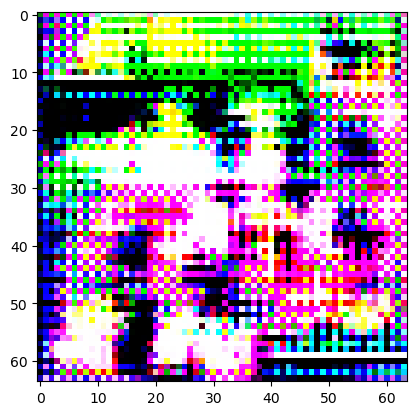

In [97]:
import matplotlib.pyplot as plt

tensor = (generated_image + 1) * 127.5

# Convert the tensor to a Numpy array and convert dtype to uint8
image_array = tensor.astype('uint8')

# Plot the image
plt.imshow(image_array[0])
plt.show()

The generated image from our generator is far from ideal, more like a random noise. There are several reasons for this. For instance, one is that the training epochs is still not enough. Another is that training discriminator and generator together might be difficult to learn, so in further step, we will show how we first freeze generator and only train discriminator to see how the model would perform.

#### Only training discriminator and see how it performs

In [87]:
discriminator_model.trainable = True

batch_size = 64
num_discriminator_steps = 50
for i in range(num_discriminator_steps):
    print(f"Epoch {i+1}")
    for i, (real_images, text_embeddings, fake_text_embeddings) in enumerate(dataset):
        # create noise vectors for the generator
        noise = tf.random.normal((batch_size, noise_size))
        
        with tf.GradientTape() as tape:
            fake_images = generator_model([noise, text_embeddings])
            # discriminate real and fake images
            real_output = discriminator_model([real_images, text_embeddings], training=True)
            fake_output1 = discriminator_model([fake_images, text_embeddings], training=True)
            fake_output2 = discriminator_model([real_images, fake_text_embeddings], training=True)

            # calculate the discriminator loss
            real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)

            fake_loss1 = binary_cross_entropy(tf.zeros_like(fake_output1), fake_output1)
            fake_loss2 = binary_cross_entropy(tf.zeros_like(fake_output2), fake_output2)

            disc_loss = real_loss + (fake_loss1 + fake_loss2)/2
        gradients = tape.gradient(disc_loss, discriminator_model.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients, discriminator_model.trainable_variables))

        if i % 20 == 0:
            print(f"Batch {i}: Discriminator loss: {disc_loss.numpy()}")
    threshold = 0.5
    label1 = np.where(real_output[0][0][0] >= threshold, 1, 0)[0]
    label2 = np.where(fake_output1[0][0][0] >= threshold, 1, 0)[0]
    label3 = np.where(fake_output2[0][0][0] >= threshold, 1, 0)[0]

    print("Real prediction:", label1, ", fake image real text prediction:", label2, ", fake text real image prediction:", label3)



Epoch 1
Batch 0: Discriminator loss: 1.7382047176361084
Real prediction: [0] , fake image real text prediction: [0] , fake text real image prediction: [0]
Epoch 2
Batch 0: Discriminator loss: 1.0334216356277466
Real prediction: [1] , fake image real text prediction: [0] , fake text real image prediction: [1]
Epoch 3
Batch 0: Discriminator loss: 0.9733463525772095
Real prediction: [1] , fake image real text prediction: [0] , fake text real image prediction: [1]
Epoch 4
Batch 0: Discriminator loss: 0.9604384303092957
Real prediction: [1] , fake image real text prediction: [0] , fake text real image prediction: [1]
Epoch 5
Batch 0: Discriminator loss: 0.9558674097061157
Real prediction: [1] , fake image real text prediction: [0] , fake text real image prediction: [1]
Epoch 6
Batch 0: Discriminator loss: 0.9512818455696106
Real prediction: [1] , fake image real text prediction: [0] , fake text real image prediction: [1]
Epoch 7
Batch 0: Discriminator loss: 0.9463642835617065
Real predictio

In [88]:
print("Real prediction:", label1, ", fake image real text prediction:", label2, ", fake text real image prediction:", label3)


Real prediction: [1] , fake image real text prediction: [0] , fake text real image prediction: [0]


According to the predictions of discriminator, we could tell that it's able to distinguish real images and real text pairs from the other two fake pairs (fake image+real text and real image+fake text).

To sum up, we trained the GAN and plotted the images generated by the generator of our trained model. However, even though we tried different methods, the results are still far from satisfactory. That is, we tried to use pre-processed images with transparent paddings or the images that are central cropped. We also tried both the pretrained embeddings encoded with Char-CNN-RNN and the embeddings we gained using BERT. 
Given the bad results, we further investigated different parts of the model to gain some insights. First of all, we tried to first train and optimize the discriminator. However, the trained discriminator is only able to label the fake image and real text embedding pair as the false, and it's not able to distinguish between the real image-real text embedding and the real image-fake text embedding. We suspected that this is because the image is taking the major role of classification and that it is only able to detect the image part, the textual part is not learned but instead adding confusion to the model. To test this hypothesis, we trained the discriminator only with real image-real text and fake image-real text, and the loss goes to 0, which verifies our guess. Therefore, our future direction is to improve the discriminator and modify the structure to make it learn both image and textual information.

In [28]:
# import necessary packages
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from PIL import Image
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Conv2DTranspose, Conv2D, LeakyReLU, BatchNormalization, Embedding, Flatten, Dropout
from tensorflow.keras.models import Model
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import PIL

### Load and Preprocess Data

In this step, we defined an object detection method using CV2 to identify bird objects from the figure. The intuition behind this method is that sometimes the bird is not on the center of the figure where the "central crop" method and cut half of the bird's body. The following method will find contours of the image and identify the largest one as the bird object. One limitation is that sometimes the bird is not always the largest object in the image, such that this function sometimes capture the backgrounds as the main object where we had to manually picked them out later. Overall, comparing to the training data obtained from using central croping, we didn't see major effects on the training process. 

In [29]:
import cv2
import os

def crop_birds(folder_path, output_dir, size=(224, 224)):
    image_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.jpg') or file_name.endswith('.png')]
    for file_name in image_files:
        image_path = os.path.join(folder_path, file_name)
        # Load the image
        #print(image_path)
        image = cv2.imread(image_path)
        #plt.imshow(image)
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply a threshold to the image to segment the bird object
        threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Find contours in the thresholded image
        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Loop over the contours and find the largest one (which should be the bird object)
        max_contour = None
        max_area = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_contour = contour
                max_area = area

        # If a contour was found, crop the image to the bounding box of the contour
        if max_contour is not None:
            x, y, w, h = cv2.boundingRect(max_contour)
            cropped_image = image[y:y+h, x:x+w]

            # Pad the image if it is not square
            height, width, _ = cropped_image.shape
            if height != width:
                padding = abs(height - width) // 2
                if height > width:
                    cropped_image = cv2.copyMakeBorder(cropped_image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=(255, 255, 255))
                else:
                    cropped_image = cv2.copyMakeBorder(cropped_image, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))
            
            # Resize the image to the desired size
            cropped_image = cv2.resize(cropped_image, size)

            # Save the image to the output directory with the same filename
            filename = os.path.basename(image_path)
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, cropped_image)
            #print(output_path)

        else:
            print(f"No bird object found in {image_path}")


In [31]:
crop_birds("./CUB_200_2011/images/054.Blue_Grosbeak","./object_detection/",size=(224, 224))

./object_detection/Blue_Grosbeak_0057_37116.jpg
./object_detection/Blue_Grosbeak_0023_37069.jpg
./object_detection/Blue_Grosbeak_0093_37107.jpg
./object_detection/Blue_Grosbeak_0082_36991.jpg
./object_detection/Blue_Grosbeak_0107_36696.jpg
./object_detection/Blue_Grosbeak_0009_36992.jpg
./object_detection/Blue_Grosbeak_0071_36948.jpg
./object_detection/Blue_Grosbeak_0048_36809.jpg
./object_detection/Blue_Grosbeak_0029_37197.jpg
./object_detection/Blue_Grosbeak_0004_14988.jpg
./object_detection/Blue_Grosbeak_0081_37034.jpg
./object_detection/Blue_Grosbeak_0079_36656.jpg
./object_detection/Blue_Grosbeak_0067_36965.jpg
./object_detection/Blue_Grosbeak_0049_37180.jpg
./object_detection/Blue_Grosbeak_0074_37155.jpg
./object_detection/Blue_Grosbeak_0016_36862.jpg
./object_detection/Blue_Grosbeak_0033_36980.jpg
./object_detection/Blue_Grosbeak_0066_36632.jpg
./object_detection/Blue_Grosbeak_0025_36646.jpg
./object_detection/Blue_Grosbeak_0085_36990.jpg
./object_detection/Blue_Grosbeak_0086_36

### Define data augmentation methods

In [7]:
#augmentation functions
import random
# Define a function to apply random rotations to the image
def random_rotation(image, rotation_range):
    angle = random.uniform(-rotation_range, rotation_range)
    return image.rotate(angle)

def random_flip(image):
    if random.random() > 0.5:
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    else:
        return image

# Define a function to apply random crops to the image
def random_crop(image, crop_size):
    width, height = image.size
    crop_height, crop_width = crop_size
    
    left = random.randint(0, width - crop_width)
    top = random.randint(0, height - crop_height)
    right = left + crop_width
    bottom = top + crop_height
    cropped_image = image.crop((left, top, right, bottom))
    pad_left = left
    pad_top = top
    pad_right = width - right
    pad_bottom = height - bottom
    padding = (pad_left, pad_top, pad_right, pad_bottom)
    padded_image = PIL.ImageOps.expand(cropped_image, padding, fill=0)
    return padded_image


def center_crop(img, new_width=None, new_height=None):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

### Define a one-step funtion that down size the image the perform data augmentation at the same time

In [8]:
from PIL import ImageOps
def resize_augment(folder_path, output_folder_path, size, num_augmentation):
    image_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.jpg') or file_name.endswith('.png')]
    for file_name in image_files:
        image_path = os.path.join(folder_path, file_name)
        with Image.open(image_path) as image:
            tmp = cv2.resize(center_crop(asarray(image)), dsize = size,interpolation=cv2.INTER_AREA)
            resized_image = Image.fromarray(tmp)
            output_path = os.path.join(output_folder_path, file_name)
            resized_image.save(output_path)
            for i in range(num_augmentation):   # can modify    
                aug_image = random_rotation(resized_image, 10)
                aug_image = random_flip(aug_image)
                aug_image = random_crop(aug_image, (15, 15))
                plt.imshow(aug_image)
                new_file_name = 'agu{}'.format(i)
                new_file_path = os.path.join(output_folder_path, new_file_name+file_name)
                aug_image.save(new_file_path)

## Train model on 16*16 images

Here we resized our image into 16 x 16 and augmented 200 times for each image in the dataset. Below is an example image downsizing to 16 x 16. Given the high resolution challenge and the challenge of diverse dataset as we described in the video, we decided to only focus on Scarlet Tanager as our training data. At the same time, we broke our model trianing process into smaller components where we decided to first train a naive GAN model to make sure we have a generator architecture that can captures birds' feature before moving on to add text embeddings.

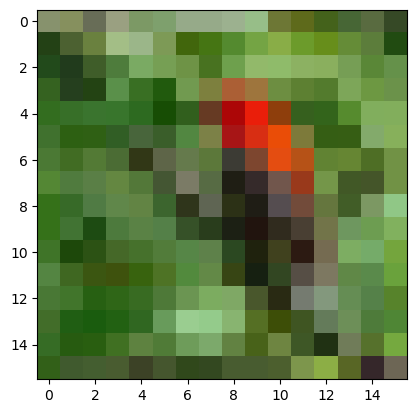

In [14]:
resize_augment("./resized_image/139.Scarlet_Tanager", "./Scarlet_Tanager16_16/", (16,16), 200)

### Load image from the path and create tensor object

In [15]:
from PIL import Image
import PIL
folder_path = "./Scarlet_Tanager16_16"

images = []
image_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.jpg') or file_name.endswith('.png')]
for file_name in image_files:
    image_path = os.path.join(folder_path, file_name)
    with Image.open(image_path) as img:
        img = np.array(img)
        images.append(img)
# Convert the list of images to a NumPy array
images = np.array(images)

In [16]:
images.shape

(6432, 16, 16, 3)

In [17]:
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.batch(64, drop_remainder=True).prefetch(1)

## Baseline GAN

Here we design the baseline GAN that takes a random noise and produce a generated image. The model has several layers of Conv2DTranspose, BatchNormalization, and LeakyReLU for better optimzation and trainig process. The depth of the model mainly depend on the size of input image. The models for training larger sized images were built by freezing the weights of the pretrained model and add more covolutional layers.

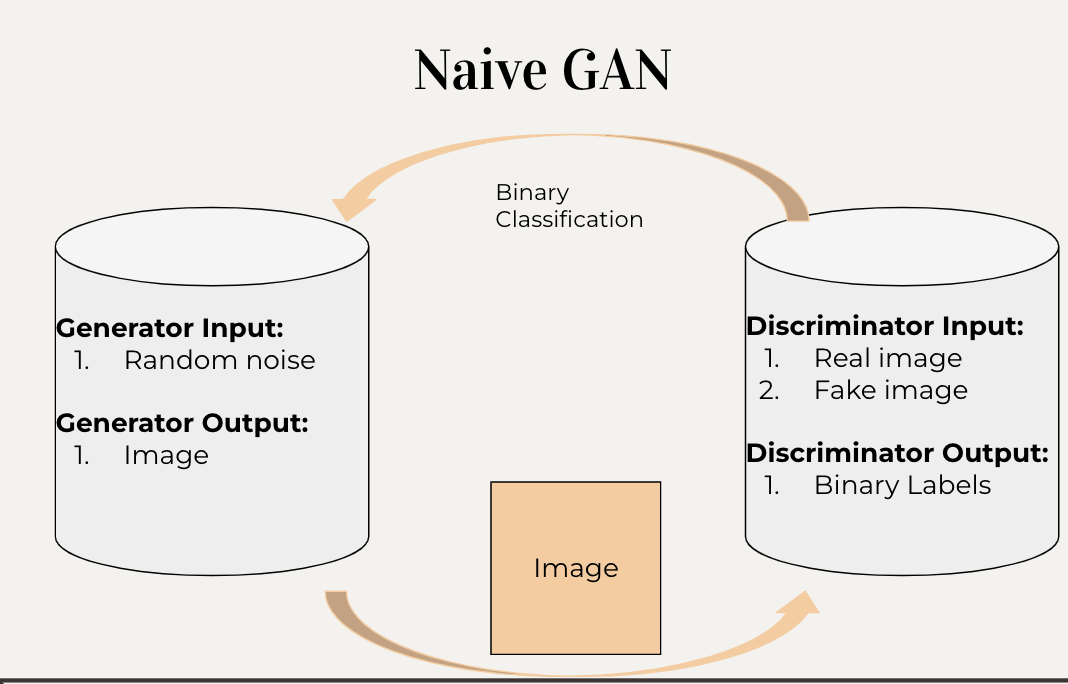

In [120]:
from IPython.display import Image
Image(filename='GAN_flowchart.png')


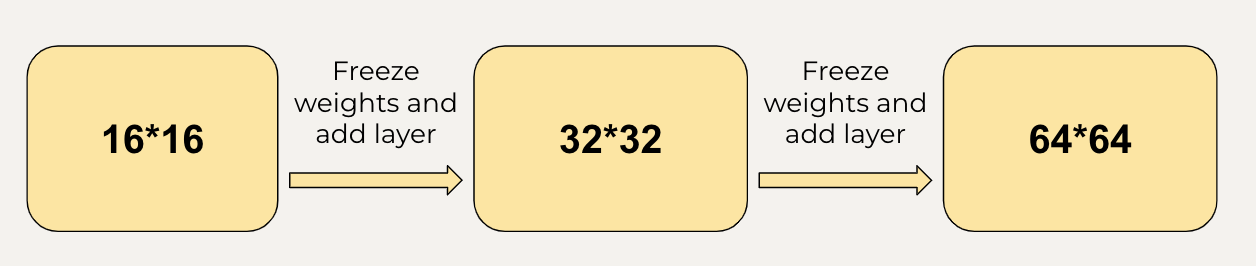

In [121]:
Image(filename='GAN_flowchart2.png')

In [82]:
noise_dim = 100
# img_shape = 
def build_generator():
    model = tf.keras.Sequential()
    model.add(Dense(4*4*1024, use_bias = False, input_shape = (noise_dim, )))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((1, 1, 16384)))
    #assert model.output_shape == (None, 1, 1, 1024)
    
    model.add(Conv2DTranspose(512, (3,3), strides = (2,2), padding = 'same', use_bias = False ))
    #assert model.output_shape == (None, 8,8,512)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(256, (3,3), strides = (2,2), padding = 'same', use_bias = False ))
    #assert model.output_shape == (None, 16,16,256)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(128,(3,3), strides = (2,2), padding = 'same', use_bias = False ))
    #assert model.output_shape == (None, 32,32,128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64,(3,3), strides = (2,2), padding = 'same', use_bias = False ))
    #assert model.output_shape == (None, 64,64,64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(3,(3,3), strides = (1,1), padding = 'same', use_bias = False , activation = 'tanh'))
    #assert model.output_shape == (None, 64,64,3)
    #model.add(Reshape((16, 16, 3)))
    #assert model.output_shape == (None, 16,16,3)
    return model

#dcgen = build_generator()

def build_discriminator():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, (3,3), strides = (2,2), padding = 'same', input_shape = [32,32,3]))
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, (3,3), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(256, (3,3), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

dcdis = build_discriminator()

In [83]:
dcgen32.summary()
dcdis.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12_input (InputLayer)  [(None, 100)]            0         
                                                                 
 dense_12 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_16 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 1, 16384)       0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 2, 2, 512)        75497472  
 Transpose)                                                

In [84]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

def discriminator_real_loss(real_output):
    return cross_entropy(tf.ones_like(real_output), real_output)

def discriminator_fake_loss(fake_output):
    return cross_entropy(tf.zeros_like(fake_output), fake_output)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [85]:
discriminator_real_optimizer = Adam(learning_rate=0.0001)
discriminator_fake_optimizer = Adam(learning_rate=0.0001)
generator_optimizer = Adam(learning_rate=0.0001)
BATCH_SIZE = 64

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
#     print(noise)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_real_tape, tf.GradientTape() as disc_loss_tape:
        
        generated_images = dcgen32(noise, training = True)
        real_output = dcdis(images, training = True)
        fake_output = dcdis(generated_images, training = True)
        
        gen_loss = generator_loss(fake_output)
        disc_real_loss = discriminator_real_loss(real_output)
        disc_fake_loss = discriminator_fake_loss(fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, dcgen32.trainable_variables)
    gradients_of_real = disc_real_tape.gradient(disc_real_loss, dcdis.trainable_variables)
    gradients_of_fake = disc_loss_tape.gradient(disc_fake_loss, dcdis.trainable_variables)
    
    discriminator_real_optimizer.apply_gradients(zip(gradients_of_real, dcdis.trainable_variables))
    discriminator_fake_optimizer.apply_gradients(zip(gradients_of_fake, dcdis.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, dcgen32.trainable_variables))

In [86]:
checkpoint_dir = './project_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                discriminator_real_optimizer = discriminator_real_optimizer, 
                                discriminator_fake_optimizer = discriminator_fake_optimizer,
                                generator = dcgen32, discriminator = dcdis)

In [87]:
from IPython.display import clear_output

# do some computations or display some output

# clear_output(wait=True) # this will clear the output of the current cell
# seed = 109
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        clear_output(wait = True)
        generate_and_save_img(dcgen32, epoch + 1, seed)
        
        if (epoch + 1)%5 == 0:
            dcgen32.save(checkpoint_dir)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    clear_output(wait = True)
    generate_and_save_img(dcgen32, epochs, seed)

In [88]:
def generate_and_save_img(model, epoch, test_input):
    predictions = model(test_input, training = False)
    
    fig = plt.figure(figsize = (8,8))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(np.array((predictions[i, :,:,:]*127.5+127.5), np.int32))
        plt.axis('off')
    
    plt.savefig('./GAN_test_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [89]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 4
BATCH_SIZE = 64

seed = tf.random.normal([num_examples_to_generate, noise_dim])

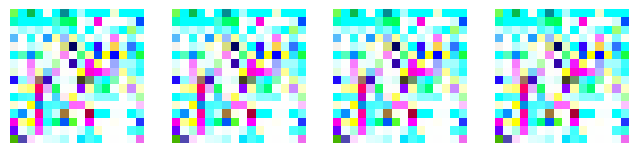

In [27]:
train(dataset, EPOCHS)

## Analysis
Given the output of the model, we can see that the model did learn some feature about the about the bird's color in the middle of the image. At the same time, sove dark pixels were added on the top to represent the black wings. We were overall satisfied with this model where we save the weigths and use it to build the model for 32*32 images.

In [29]:
dcgen.save("dcgen_new_16.h6")

2023-05-08 20:06:32.091633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,16384]
	 [[{{node inputs}}]]
2023-05-08 20:06:32.143356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-08 20:06:32.194146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
20

INFO:tensorflow:Assets written to: dcgen_new_16.h6/assets


INFO:tensorflow:Assets written to: dcgen_new_16.h6/assets


## Training on 32*32 image size

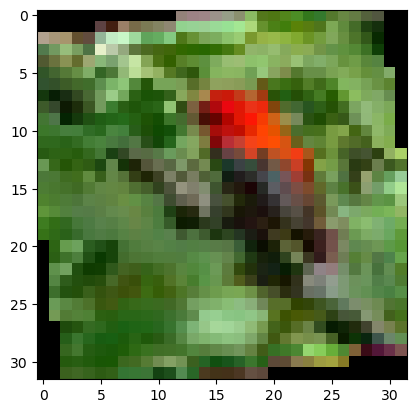

In [30]:
resize_augment("./resized_image/139.Scarlet_Tanager", "./Scarlet_Tanager32_32/", (32,32), 200)

In [60]:
from PIL import Image
import PIL
folder_path = "./Scarlet_Tanager32_32"

images = []
image_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.jpg') or file_name.endswith('.png')]
for file_name in image_files:
    image_path = os.path.join(folder_path, file_name)
    with Image.open(image_path) as img:
        img = np.array(img)
        images.append(img)
# Convert the list of images to a NumPy array
images = np.array(images)

In [61]:
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.batch(64, drop_remainder=True).prefetch(1)

After preprocessed and loading the data, we here added another twp covlutional layers on top of prior model and freeze the weights to preserve learned features. This model would be used to train and generate image of 32*32. The goal is to be able to upscale ot 64*64 with good accuracy.

In [90]:
for layer in dcgen.layers:
    layer.trainable = False
    
x = dcgen.output
x = Conv2DTranspose(512, (3,3), strides = (2,2), padding = 'same', use_bias = False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
output_layer = Conv2DTranspose(3,(3,3), strides = (1,1), padding = 'same', use_bias = False , activation = 'tanh')(x)


In [91]:
dcgen32 = tf.keras.Model(inputs=dcgen.input, outputs=output_layer)

In [92]:
dcgen32.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12_input (InputLayer)  [(None, 100)]            0         
                                                                 
 dense_12 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_16 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 1, 16384)       0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 2, 2, 512)        75497472  
 Transpose)                                                

In [93]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 4
BATCH_SIZE = 64

seed = tf.random.normal([num_examples_to_generate, noise_dim])

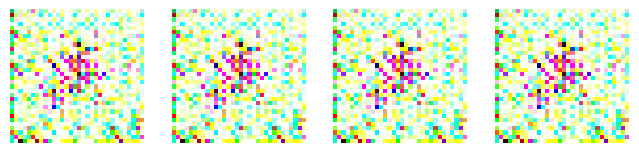

Time for epoch 1 is 43.722728967666626 sec


KeyboardInterrupt: 

In [95]:
#key board interruption because of the long training time 
#- the model was trained was 250 epochs before
train(dataset, EPOCHS)

### Analysis
We used keyboard to interrupt the model training process as it has already trained for 250 epoch and given the time span for training the model. Overall we are pretty satisfied with this current version of model as it seems to perform better in capturing the outline of the bird where the shape was pretty clear and the color was red with some dark pixels on top representing the balck wings.

## Retrain model on 64*64 images

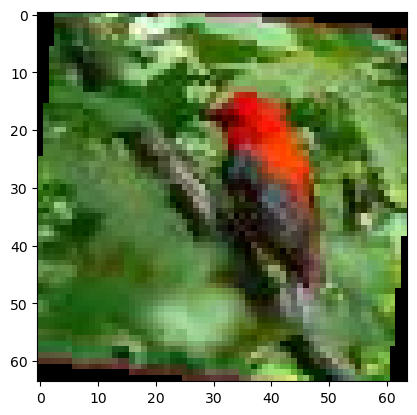

In [97]:
resize_augment("./resized_image/139.Scarlet_Tanager", "./Scarlet_Tanager64_64/", (64,64), 200)

In [99]:
from PIL import Image
import PIL
folder_path = "./Scarlet_Tanager64_64"

images = []
image_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.jpg') or file_name.endswith('.png')]
for file_name in image_files:
    image_path = os.path.join(folder_path, file_name)
    with Image.open(image_path) as img:
        img = np.array(img)
        images.append(img)
# Convert the list of images to a NumPy array
images = np.array(images)

In [100]:
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.batch(64, drop_remainder=True).prefetch(1)

After training 32*32 model and achieved a satified results, we move on to the next image size, 64*64. We follow the similar training procesure as before by adding 2 layers to increase depth and freeze the prior model weights.

In [101]:
for layer in dcgen32.layers:
    layer.trainable = False
    
x = dcgen32.output
x = Conv2DTranspose(512, (3,3), strides = (2,2), padding = 'same', use_bias = False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
output_layer = Conv2DTranspose(3,(3,3), strides = (1,1), padding = 'same', use_bias = False , activation = 'tanh')(x)


In [102]:
dcgen64 = tf.keras.Model(inputs=dcgen.input, outputs=output_layer)

In [103]:
dcgen64.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12_input (InputLayer)  [(None, 100)]            0         
                                                                 
 dense_12 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_16 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 1, 16384)       0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 2, 2, 512)        75497472  
 Transpose)                                                

In [111]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, (3,3), strides = (2,2), padding = 'same', input_shape = [64,64,3]))
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, (3,3), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(256, (3,3), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

dcdis = build_discriminator()

In [112]:
dcdis.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_32 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_33 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 8, 128)       

In [113]:
discriminator_real_optimizer = Adam(learning_rate=0.0001)
discriminator_fake_optimizer = Adam(learning_rate=0.0001)
generator_optimizer = Adam(learning_rate=0.0001)
BATCH_SIZE = 64

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
#     print(noise)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_real_tape, tf.GradientTape() as disc_loss_tape:
        
        generated_images = dcgen64(noise, training = True)
        real_output = dcdis(images, training = True)
        fake_output = dcdis(generated_images, training = True)
        
        gen_loss = generator_loss(fake_output)
        disc_real_loss = discriminator_real_loss(real_output)
        disc_fake_loss = discriminator_fake_loss(fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, dcgen64.trainable_variables)
    gradients_of_real = disc_real_tape.gradient(disc_real_loss, dcdis.trainable_variables)
    gradients_of_fake = disc_loss_tape.gradient(disc_fake_loss, dcdis.trainable_variables)
    
    discriminator_real_optimizer.apply_gradients(zip(gradients_of_real, dcdis.trainable_variables))
    discriminator_fake_optimizer.apply_gradients(zip(gradients_of_fake, dcdis.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, dcgen64.trainable_variables))

In [114]:
checkpoint_dir = './project_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                discriminator_real_optimizer = discriminator_real_optimizer, 
                                discriminator_fake_optimizer = discriminator_fake_optimizer,
                                generator = dcgen64, discriminator = dcdis)

In [115]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        clear_output(wait = True)
        generate_and_save_img(dcgen64, epoch + 1, seed)
        
        if (epoch + 1)%5 == 0:
            dcgen64.save(checkpoint_dir)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    clear_output(wait = True)
    generate_and_save_img(dcgen64, epochs, seed)

In [116]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 4
BATCH_SIZE = 64

seed = tf.random.normal([num_examples_to_generate, noise_dim])

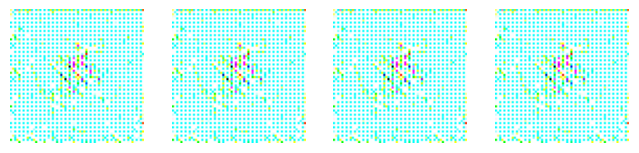

2023-05-09 03:27:35.044067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,16384]
	 [[{{node inputs}}]]
2023-05-09 03:27:35.095831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-09 03:27:35.147324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
20

INFO:tensorflow:Assets written to: ./project_checkpoints/assets


INFO:tensorflow:Assets written to: ./project_checkpoints/assets


Time for epoch 150 is 73.40661096572876 sec


KeyboardInterrupt: 

In [117]:
train(dataset, EPOCHS)

### Analysis
Overall the model capture some level of image complexity of read features and shape. However, compared to the previous models, the model still have space for improvement in better defining the bird's shape and color. We believe that after a few hundreds of epoch the model should have the ability to capture and generate bird features as good as prior models. 

## Conclusion

In this project, we learned the challenges in building and training a complex GAN model. Specifically, we identified that experience, a large enough computing resource and a feasible training dataset are imperative to the success of training such a model. 

Unfortunately, none of the team member has the experience to develop and train a GAN mdoel before this class. Thus, it makes it very challenging to debug what potentially errors might be in the model design. 

At the same time, the long training time and limited computing resource is another limitation to our model. We understand that a good GAN models needs to have large enough parameters to capture all features from the picutre, especially in the colored picture case. However, training such a complex model requires times and huge computing resources for experimentation and fine-tuning.

Lastly, we realize that our dataset might also limit our capability in a successful GAN model. Even after we fix the bird category, we realized that there were still huge variations between the backgrounds and the directions the photo of the birds was taken, which might further confuse the model into detecting which is the right features to learn.

However, we were able to find that training from a low resolutional image and building up gradually seems like the right way to approach this project. We believe such finding would provide valuable direction for the future direction of such project when building the model from scratch.

## Future Directions
In the future, we plan to accquire for larger computing resources to better prepare for model training and building. At the same time, we think having enough parameters and depth of model is important such that we would add more layers to our architecture. Finally, we think we might be able to adapt the concept of transfer learning and adopt pre-trained model such as VGG to better capture image featuers and thus improve performance. With a better generator, we would then circle back to include this new generator in the old design and train the old cGAN model again.

Thanks for reading our project!